In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
from math import floor

In [2]:
# Create units for model
m = UNITS.meter
s = UNITS.seconds
kg = UNITS.kilogram
degree = UNITS.degree
N = UNITS.newton
K = UNITS.kelvin
C = UNITS.celsius
F = UNITS.fahrenheit
W = UNITS.watt
J = UNITS.joule
Pa = UNITS.pascal

<Unit('pascal')>

In [3]:
T_0 =  385 * K # 288 inital (326.84 neutral buoyant)
x_0 = 0 *m
y_0 = 0 * m
vx_0 = 0 * (m/s)
vy_0 = 0 * (m/s)

init = State(T=T_0,
            x=x_0,
            y=y_0,
            vx = vx_0,
            vy=vy_0)

,values
T,385 kelvin
x,0 meter
y,0 meter
vx,0 meter / second
vy,0 meter / second


In [4]:
system1 = System(init = init,
                g = -9.8 * m/s**2,
                mass = 613 * kg,   #210 F air (805 kg) + human (105 lb) + hot air balloon mass # 925.656 kg w air. MASS TOO HEAVY
                diameter = 15 * m,     #diameter of the hopper hot air balloon
                volume = 2200 * m**3,  #volume of hopper
                p_air = 1.2 * kg/m**3, #density (rho) of dry air
                coeff_d = 0.47,        #coefficient of drag
                area = 706.8 * m**2,   #cross sectional area of ballon for drag and wind force 
                gas_constant = 287.05 * J/(kg * K), #gas constant for pressure equation
                air_pressure = 101325 * Pa,       #constant air pressure 
                wind_speed = 25 , #wind speed for cross wind 4.4 = 10mph
                t_0 = 0 *s,             #start time of simulation
                t_end = 120 * s)        #end time of simulation

,values
init,T 385 kelvin x 0 meter ...
g,-9.8 meter / second ** 2
mass,613 kilogram
diameter,15 meter
volume,2200 meter ** 3
p_air,1.2 kilogram / meter ** 3
coeff_d,0.47
area,706.8 meter ** 2
gas_constant,287.05 joule / kelvin / kilogram
air_pressure,101325 pascal


In [5]:
def density_in(state, system):
    unpack(system1)
    T, x, y, vx, vy = state
    density_in = air_pressure / (gas_constant * T)
    
    return density_in

In [6]:
density_in(init,system1)

<Quantity(0.9168500894681003, 'kilogram * pascal / joule')>

In [7]:
def buoyant_force(state, system):
    """Computes buoyant force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    T, x, y, vx, vy = state
    unpack(system1)
    
    d = Vector(0 * (m/s**2),-g)
    
    balloon_density = density_in(state,system)
    f_b_mag = volume * (p_air - balloon_density) * d.mag
    direction = d.hat()
    f_b = direction * f_b_mag
    return f_b

In [8]:
buoyant_force(init, system1)

<Quantity([   0.         6104.71207107], 'kilogram * meter / second ** 2')>

In [9]:
def drag_force(state, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity vector
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    T, x, y, vx, vy = state
    unpack(system1)
    V = Vector(vx, vy)
    mag = p_air * V.mag**2 * coeff_d * area / 2
    direction = -V.hat()
    f_drag = direction * mag
    return f_drag

In [10]:
drag_force(init,system1)

<Quantity([0. 0.], 'kilogram * meter / second ** 2')>

In [11]:
def wind_force(state, system):
    """Computes force of cross wind based on wind speed
    
    """
    
    T, x, y, vx, vy = state
    unpack(system1)
    direction = Vector(1,0)
    wind_pressure = (wind_speed**2) * 0.613 * (N/(m**2))
    mag = area * coeff_d * 0.613 * wind_pressure
    wind_force = direction * mag
    
    return wind_force

In [12]:
wind_force(init,system1)

<Quantity([78018.0992025     0.       ], 'newton')>

In [13]:
def slope_func_heat(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    T, x, y, vx, vy = state
    unpack(system1)
    
    
    dTdt = 1
    V = Vector(vx, vy)  
    a_buoyant = buoyant_force(state, system) / mass
    a_wind = wind_force(state,system) / mass
    a_drag = drag_force(state, system) / mass
    a_grav = Vector(0, g)
    
    a = a_grav + a_drag + a_wind + a_buoyant
   
        
    return dTdt, vx, vy, a.x, a.y

In [14]:
slope_func_heat(init, 0, system1)

(1,
 <Quantity(0, 'meter / second')>,
 <Quantity(0, 'meter / second')>,
 <Quantity(127.2725925, 'meter / second ** 2')>,
 <Quantity(0.1587472611219507, 'meter / second ** 2')>)

In [15]:
ts = linrange(system1.t_0/s, system1.t_end/s, 1)
results_heat, details = run_ode_solver(system1, slope_func_heat, t_eval = ts)

In [17]:
results_heat.tail()

,T,x,y,vx,vy
115.0,500.0,2272.320565,74.677279,19.792452,1.176887
116.0,501.0,2292.088876,75.856582,19.774943,1.183550
117.0,502.0,2311.856108,77.043508,19.768853,1.190858
118.0,503.0,2331.623145,78.238078,19.762253,1.198099
119.0,504.0,2351.389860,79.440255,19.756819,1.205376


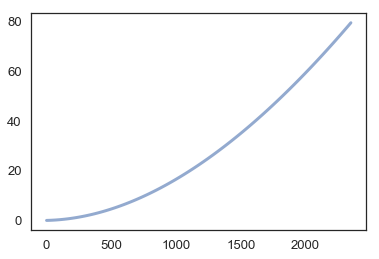

In [18]:
plot(results_heat.x, results_heat.y)

In [32]:
t_0 = get_last_label(results_heat) * s
T, x, y, vx, vy = get_last_value(results_heat)
init2 = State(T=T*K, x=x*m, y=y*m, vx=vx*m/s, vy=vy*m/s)

,values
T,503.99999999999727 kelvin
x,2351.389860202032 meter
y,79.44025529795056 meter
vx,19.7568188031536 meter / second
vy,1.2053759083223126 meter / second


In [20]:
system2 = System(system1, t_0=t_0, init=init2, t_end= 5000 *s)

,values
init,T 503.99999999999727 kelvin x ...
g,-9.8 meter / second ** 2
mass,613 kilogram
diameter,15 meter
volume,2200 meter ** 3
p_air,1.2 kilogram / meter ** 3
coeff_d,0.47
area,706.8 meter ** 2
gas_constant,287.05 joule / kelvin / kilogram
air_pressure,101325 pascal


In [21]:
def slope_func_cool(state, t, system):
    """Computes derivatives of the state variables when ballon is cooling.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (dTdt, vx, vy, ax, ay)
    """
    T, x, y, vx, vy = state
    unpack(system2)
    
    
    dTdt = -0.256
    V = Vector(vx, vy)  
    a_buoyant = buoyant_force(state, system) / mass
    a_wind = wind_force(state,system) / mass
    a_drag = drag_force(state, system) / mass
    a_grav = Vector(0, g)
    
    a = a_grav + a_drag + a_wind + a_buoyant
    #print(a_buoyant)
    #print(a_drag)
    #print(a_grav)
    #print(a_wind)
    #print(a)
    
    return dTdt, vx, vy, a.x, a.y

In [22]:
slope_func_cool(init, 0, system2)

(-0.256,
 <Quantity(0, 'meter / second')>,
 <Quantity(0, 'meter / second')>,
 <Quantity(127.2725925, 'meter / second ** 2')>,
 <Quantity(0.1587472611219507, 'meter / second ** 2')>)

In [23]:
def event_func(state, t, system):
    T, x, y, vx, vy = state
    return y

In [24]:
ts = linrange(system2.t_0/s, system2.t_end/s, 1)
results_cool, details = run_ode_solver(system2, slope_func_cool, t_eval = ts, events=event_func)
results_cool.head()

,T,x,y,vx,vy
119.0,504.000,2351.389860,79.440255,19.756819,1.205376
120.0,503.744,2371.156332,80.646500,19.752376,1.204639
121.0,503.488,2390.922067,81.850984,19.758967,1.203099
122.0,503.232,2410.687951,83.053531,19.763933,1.201454
123.0,502.976,2430.453990,84.254138,19.767680,1.199732


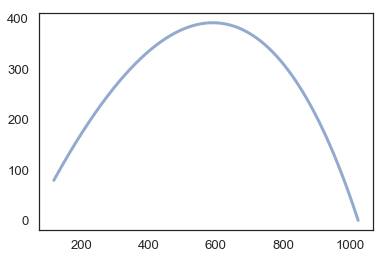

In [25]:
plot(results_cool.y)

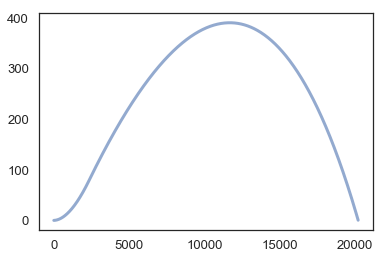

In [26]:
results = results_cool.combine_first(results_heat)
plot(results.x, results.y)

In [27]:
def AC_event_func(state, t, system):
    T, x, y, vx, vy = state
    return x - 28

In [28]:
def height_func(wind_speed, system):
    """Computes the height of the ballon when it reaches the AC.
    
    wind_speed: wind speed in m/s
    system: System object
    
    returns: height in meters
    """    
    system.wind_speed = wind_speed
    results, details = run_ode_solver(system, slope_func_heat, events=AC_event_func)
    height = get_last_value(results.y)
    
    return height

In [29]:
height_func(1.5, system1)

94.72633813776339

In [30]:
def error_func(wind_speed, system):
    """Returns the height at the AC minus the target height.
    
    velocity: initial velocity in m/s
    params: Params object
    
    returns: height difference in meters
    """    
    system.wind_speed = wind_speed
    height = height_func(wind_speed,system)
    return abs(18.9 - height)

In [31]:
min_bounded(error_func, [0,4.4], system1)

,values
fun,0.00349407
status,0
success,True
message,Solution found.
x,2.37686
nfev,17
